In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn 
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.models import Model

from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
os.chdir('C:/Users/Pushkar Rai/Waste classifcation/Datasets/train')

In [3]:
curr_path = os.getcwd()
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation\\Datasets\\train'

In [4]:
# Show the data classes
classes = os.listdir(curr_path)
classes

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

(2187, 224, 224, 3) (2187,)


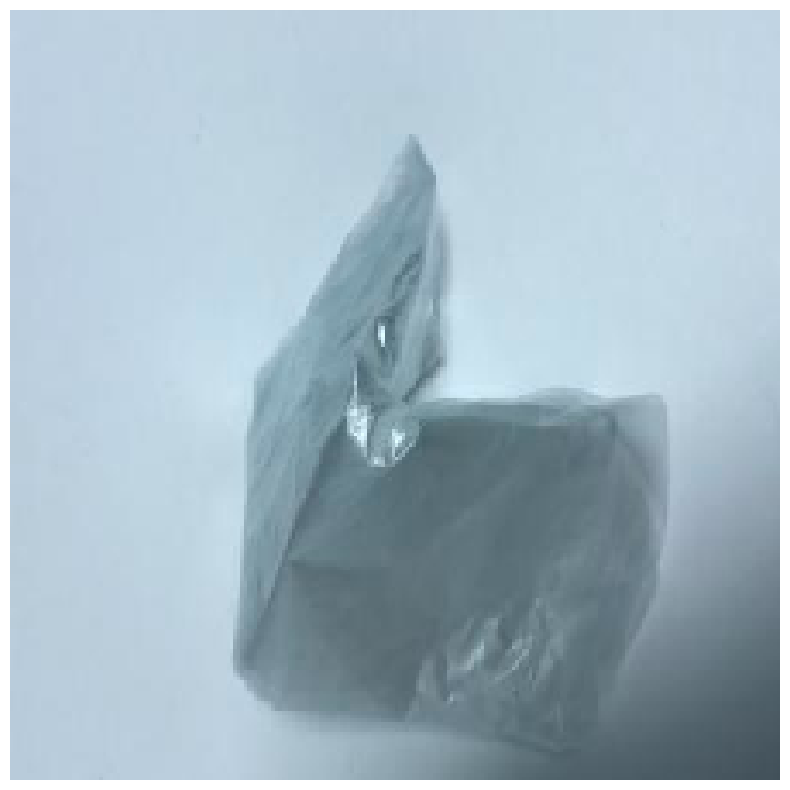

In [5]:
#Loading train datasets
train_data = []
train_labels = []
classes = 7 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        train_data.append(img)
        train_labels.append(i)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

In [6]:
os.chdir('C:/Users/Pushkar Rai/Waste classifcation/Datasets/test')

In [7]:
curr_path = os.getcwd()
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation\\Datasets\\test'

In [8]:
# Show the data classes
classes = os.listdir(curr_path)
classes

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [9]:
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation\\Datasets\\test'

In [10]:
#Loading test datasets
test_data = []
test_labels = []
classes = 7 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        test_data.append(img)
        test_labels.append(i)


test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(564, 224, 224, 3) (564,)


In [11]:
os.chdir('C:/Users/Pushkar Rai/Waste classifcation/Datasets/train')

In [12]:
curr_path = os.getcwd()
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation\\Datasets\\train'

In [13]:
# this is the augmentation configuration used for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


#this will get images fromm training data and generate batches of augmented data
training_data = training_datagen.flow_from_directory(curr_path, # train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')  #we use binary_crossentropy loss

Found 2187 images belonging to 7 classes.


In [14]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

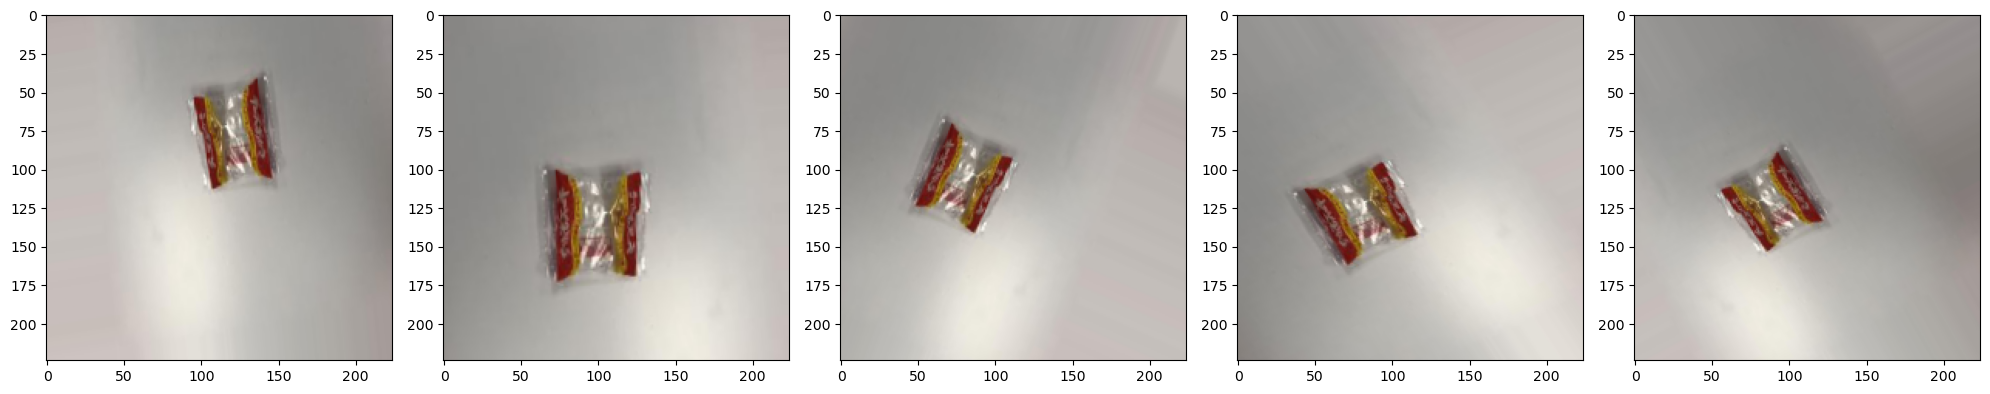

In [15]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

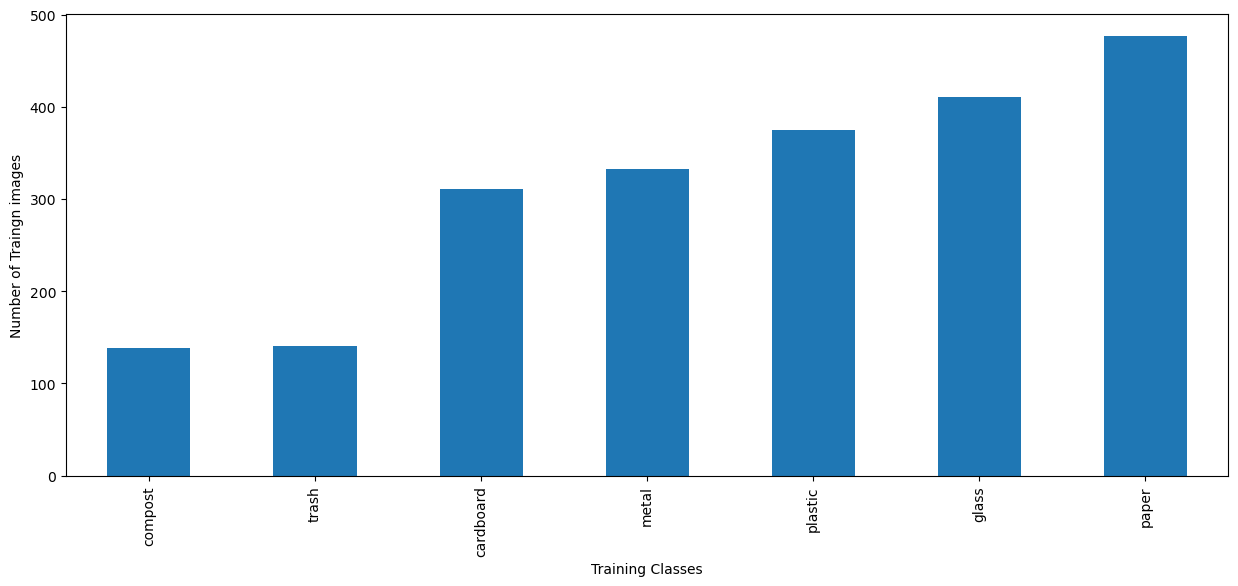

In [16]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(curr_path):
    data_dic[folder] = len(os.listdir(curr_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

In [17]:
os.chdir('C:/Users/Pushkar Rai/Waste classifcation/Datasets/test')

In [18]:
curr_path = os.getcwd()
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation\\Datasets\\test'

In [19]:
# this is the augmentation configuration we will use for testing

testing_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


testing_data = testing_datagen.flow_from_directory(curr_path,
                                      target_size=(224, 224), 
                                      batch_size=32,
                                      class_mode='categorical')  

Found 564 images belonging to 7 classes.


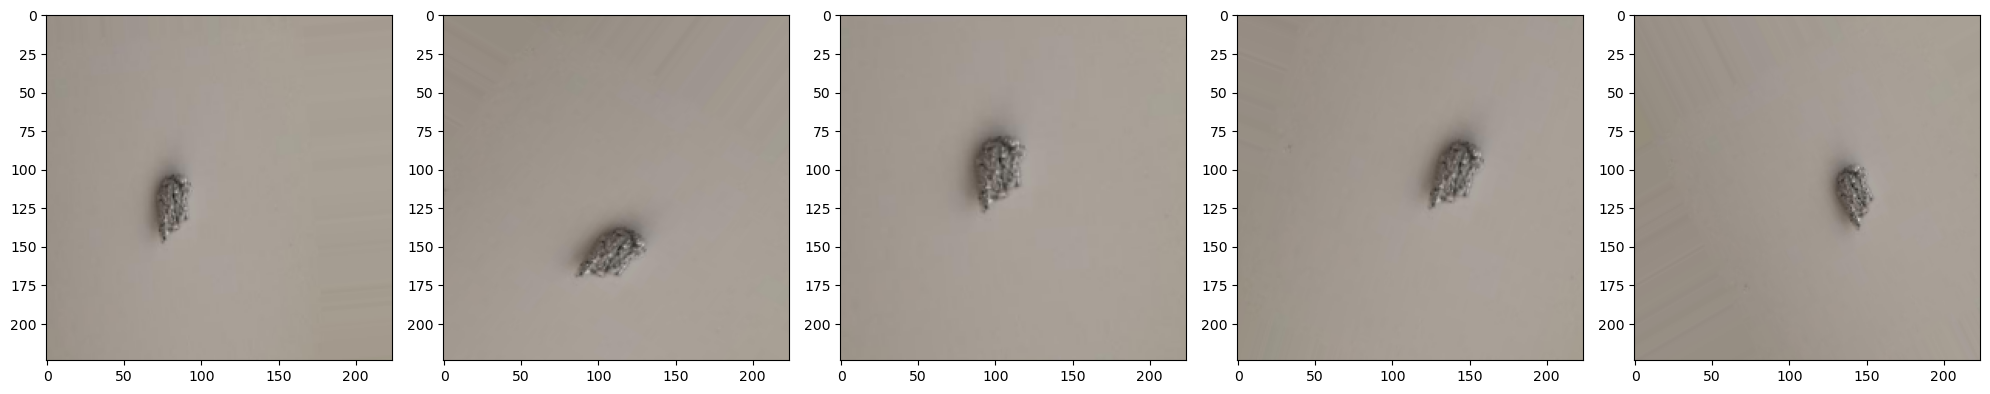

In [20]:
# showing augmented images
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Valedation images')

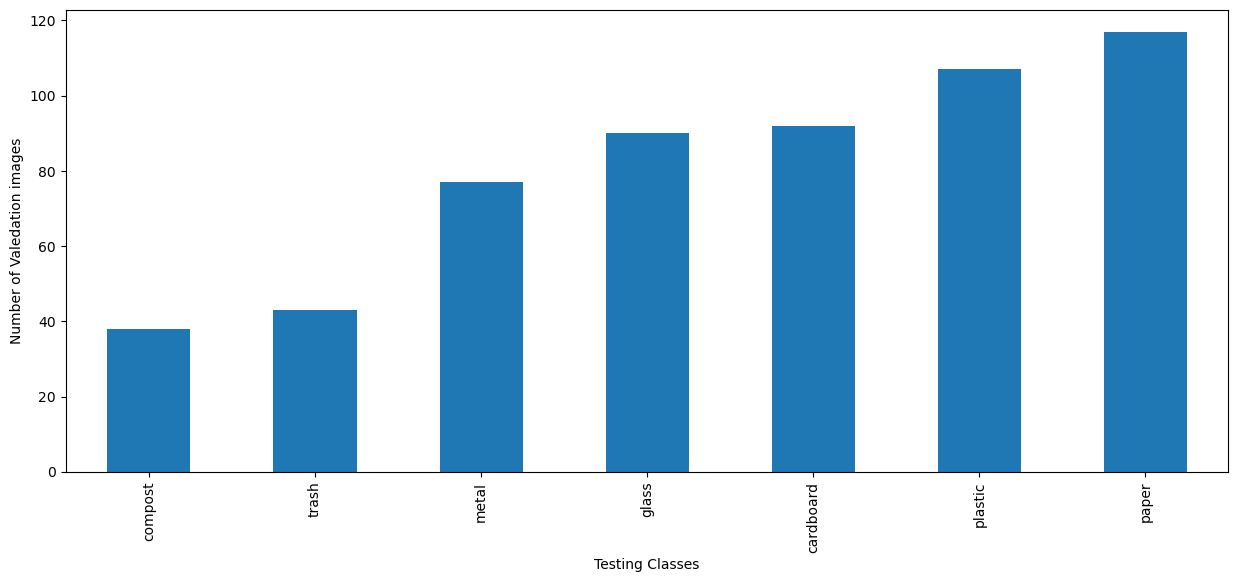

In [21]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(curr_path):
    data_dic[folder] = len(os.listdir(curr_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Valedation images')

In [22]:
IMAGE_SIZE = [224,224]

In [23]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [24]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [25]:
os.chdir('C:/Users/Pushkar Rai/Waste classifcation')

In [26]:
curr_path = os.getcwd()
curr_path

'C:\\Users\\Pushkar Rai\\Waste classifcation'

In [27]:
# useful for getting number of classes
folders = glob(curr_path + '/'+'Datasets/train/*')


In [28]:

x = Flatten()(vgg.output)

prediction = Dense(len(folders), activation='softmax')(x)

In [29]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
import tensorflow as tf

In [31]:
# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath = 'vgg16_model.weights.best.hdf5', 
                               verbose = False, 
                               save_best_only = True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 4,
                           restore_best_weights = True,
                           mode = 'min')

In [32]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

In [33]:
!pip install visualkeras
import visualkeras

ValueError: Could not save to JPEG for display

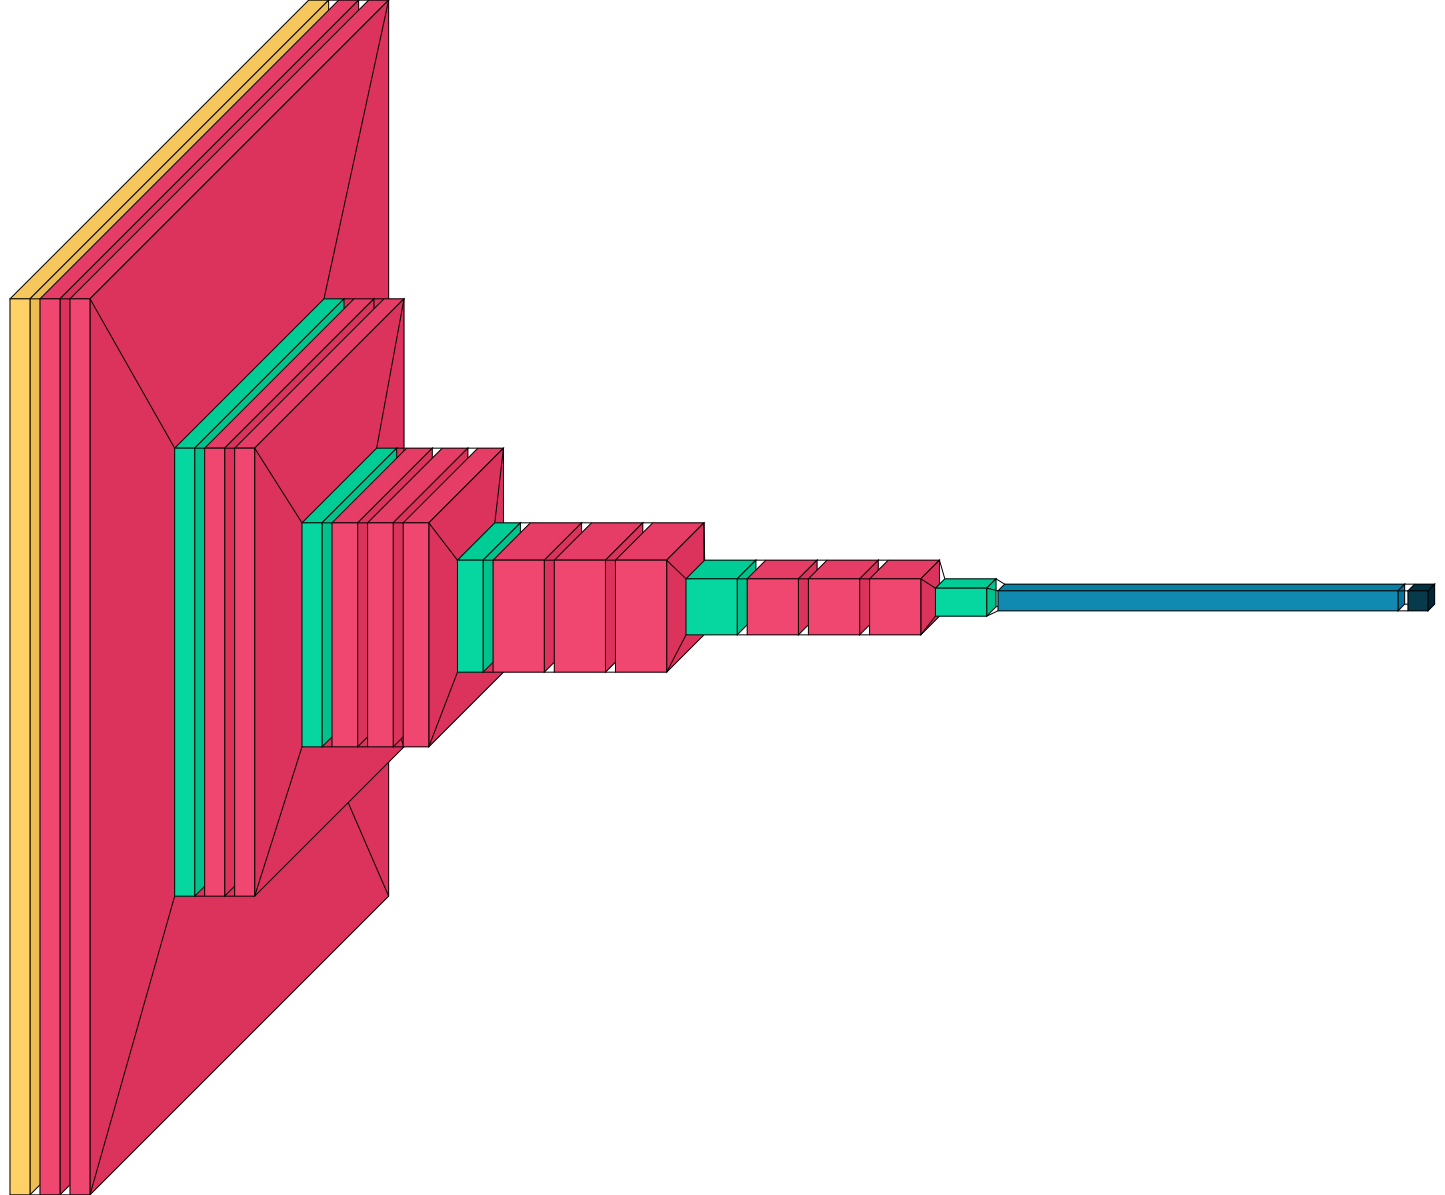

In [34]:
visualkeras.layered_view(model)

In [35]:
result = model.fit_generator(training_data,steps_per_epoch=len(training_data),epochs=5,callbacks=[early_stop, checkpointer],validation_data=testing_data,validation_steps=len(testing_data))

C:\Users\Pushkar Rai\AppData\Local\Temp\ipykernel_21480\1337646407.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(training_data,steps_per_epoch=len(training_data),epochs=5,callbacks=[early_stop, checkpointer],validation_data=testing_data,validation_steps=len(testing_data))


Epoch 1/5
69/69 [==============================] - 331s 5s/step - loss: 1.9284 - accuracy: 0.2030 - val_loss: 1.8334 - val_accuracy: 0.2730
Epoch 2/5
69/69 [==============================] - 328s 5s/step - loss: 1.7674 - accuracy: 0.2872 - val_loss: 1.7398 - val_accuracy: 0.3174
Epoch 3/5
69/69 [==============================] - 328s 5s/step - loss: 1.6843 - accuracy: 0.3498 - val_loss: 1.6661 - val_accuracy: 0.3688
Epoch 4/5
69/69 [==============================] - 327s 5s/step - loss: 1.6179 - accuracy: 0.3841 - val_loss: 1.6194 - val_accuracy: 0.3777
Epoch 5/5
69/69 [==============================] - 326s 5s/step - loss: 1.5617 - accuracy: 0.4179 - val_loss: 1.5444 - val_accuracy: 0.4291


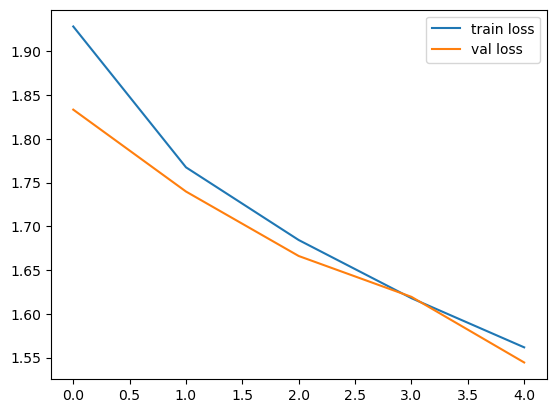

<Figure size 640x480 with 0 Axes>

In [36]:
# loss
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

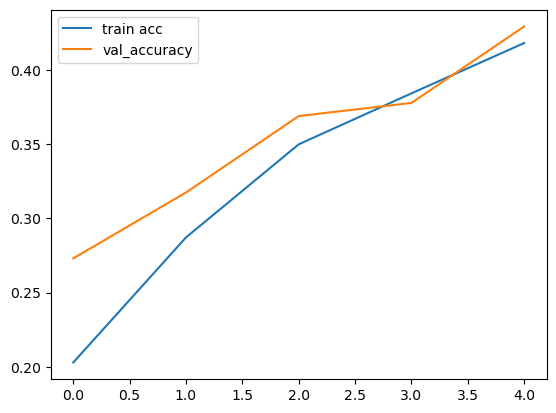

<Figure size 640x480 with 0 Axes>

In [37]:
# accuracies
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [38]:
# Score
score = model.evaluate(testing_data, verbose=0)
print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 1.5660440921783447
Test accuracy 0.3953900635242462


In [39]:
y_pred = model.predict(testing_data)

18/18 [==============================] - 69s 4s/step


In [40]:
y_pred

array([[0.36907184, 0.01859937, 0.10014364, ..., 0.24893202, 0.13119644,
        0.02929521],
       [0.14279242, 0.08331916, 0.2419123 , ..., 0.07207538, 0.16426131,
        0.03731205],
       [0.15727459, 0.18940577, 0.19907866, ..., 0.14280975, 0.1481195 ,
        0.0656074 ],
       ...,
       [0.13898084, 0.07662497, 0.25494558, ..., 0.13710582, 0.17331849,
        0.05749086],
       [0.23954982, 0.02783827, 0.11391032, ..., 0.31000924, 0.1363953 ,
        0.01894548],
       [0.14491338, 0.13109726, 0.18530646, ..., 0.2228745 , 0.15517446,
        0.04610765]], dtype=float32)

In [41]:
print(y_pred)

[[0.36907184 0.01859937 0.10014364 ... 0.24893202 0.13119644 0.02929521]
 [0.14279242 0.08331916 0.2419123  ... 0.07207538 0.16426131 0.03731205]
 [0.15727459 0.18940577 0.19907866 ... 0.14280975 0.1481195  0.0656074 ]
 ...
 [0.13898084 0.07662497 0.25494558 ... 0.13710582 0.17331849 0.05749086]
 [0.23954982 0.02783827 0.11391032 ... 0.31000924 0.1363953  0.01894548]
 [0.14491338 0.13109726 0.18530646 ... 0.2228745  0.15517446 0.04610765]]
